## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [10]:
# !tar -xf data/data_split_merged.tar.xz
# !mv data_split_merged/ data/data_split_merged

In [12]:
! ls data/

data_split_merged	  example.zip  satellite2	  smiles
data_split_merged.tar.xz  satellite    satellite2.tar.xz  who_are_they


In [13]:
path = Path('data/data_split_merged/')
path.ls()

[PosixPath('data/data_split_merged/train'),
 PosixPath('data/data_split_merged/validation_random'),
 PosixPath('data/data_split_merged/validation'),
 PosixPath('data/data_split_merged/test_random'),
 PosixPath('data/data_split_merged/test')]

In [16]:
def get_y_fn(x):
    # go one up
    x = list(x.parents)[1]/'labels'/f'{x.stem}.png'  
    assert os.path.exists(x)
    return x  

def get_new_y_fn(x):
    # go one up
    x = list(x.parents)[1]/'labels_new'/f'{x.stem}.png'  
    return x    

def my_save(mask, fname):
    x = np.array(mask.data[0]).astype(np.uint8)
    PIL.Image.fromarray(x).save(fname)

def _change_pixels(x):
    x[x==80] = 1
    x[x==134] = 2
    return x

def _dither(array, number=2):    
    copy_array = torch.zeros_like(array).type(torch.LongTensor)
    copy_array[array == number] = 1
    
    # fill horizontally
    mask = torch.LongTensor(copy_array.clone())
    copy_array[..., 1:] += mask[..., :-1]
    copy_array[..., :-1] += mask[..., 1:]
    
    # fill vertically
    mask = (copy_array >= 1).type(torch.LongTensor)
    copy_array[..., 1:, :] += mask[..., :-1, :]
    copy_array[..., :-1, :] += mask[..., 1:, :]
    
    array[copy_array > 0] =  number
    
    return array

change_pixels = TfmPixel(_change_pixels)
dither = TfmPixel(_dither)



## Data

In [20]:
!ls data/data_split_merged/validation/

labels	tiles


In [22]:
!mkdir data/data_split_merged/train/labels_new/
!mkdir data/data_split_merged/test/labels_new/
!mkdir data/data_split_merged/validation/labels_new/

In [23]:
for fname in get_image_files(path/'validation'/'tiles'):
    mask = open_mask(get_y_fn(fname))
    change_pixels(mask)
    dither(mask)
    
    assert all(np.isin(mask.data.unique(), [0, 1, 2]))
    
    
    my_save(mask, get_new_y_fn(fname))

In [26]:
!ls data/data_split_merged/validation/

labels	labels_new  tiles


In [28]:
!du -sh data/data_split_merged/validation/*

26M	data/data_split_merged/validation/labels
23M	data/data_split_merged/validation/labels_new
79M	data/data_split_merged/validation/tiles


In [29]:
for fname in get_image_files(path/'train'/'tiles'):
    mask = open_mask(get_y_fn(fname))
    change_pixels(mask)
    dither(mask)
    
    assert all(np.isin(mask.data.unique(), [0, 1, 2]))
    
    my_save(mask, get_new_y_fn(fname))

In [33]:
for fname in get_image_files(path/'test'/'tiles'):
    mask = open_mask(get_y_fn(fname))
    change_pixels(mask)
    dither(mask)
    
    assert all(np.isin(mask.data.unique(), [0, 1, 2]))
    
    my_save(mask, get_new_y_fn(fname))

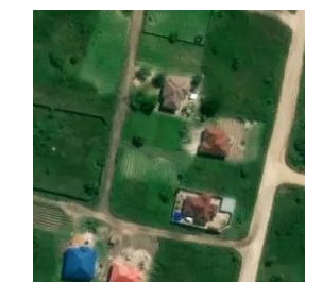

In [34]:
fnames = get_image_files(path/'train'/'tiles')
fnames[:3]

img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

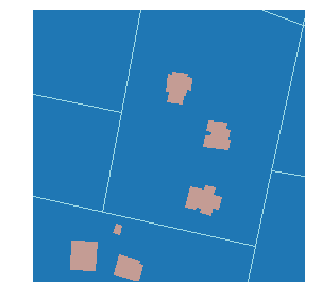

In [36]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)